(battery-eff)=
# Energieeffizienz bei Batteriesystemen

## python konfigurieren

### Module importieren

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import datetime as dt
import holidays
import seaborn as sns
import plotly
import plotly.graph_objects as go
import sys
import os
import locale
import schemdraw
import schemdraw.elements as elm
from schemdraw import flow
from distutils.spawn import find_executable
from cycler import cycler

print('Versionen der verwendeten python-Module: ')
print('numpy', np.__version__)
print('matplotlib', matplotlib.__version__)
print('pandas', pd.__version__)
print('datetime', dt)
print('holidays', holidays.__version__)
print('seaborn', sns.__version__)
print('plotly', plotly.__version__)
print('sys', sys.version)
print('os', os)
print('locale', locale)
print('schemdraw', schemdraw.__version__)

Versionen der verwendeten python-Module: 
numpy 1.21.5
matplotlib 3.5.2
pandas 1.4.4
datetime <module 'datetime' from '/home/franzi/.pyenv/versions/miniconda-latest/envs/22sye/lib/python3.10/datetime.py'>
holidays 0.11.3.1
seaborn 0.11.2
plotly 5.9.0
sys 3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
os <module 'os' from '/home/franzi/.pyenv/versions/miniconda-latest/envs/22sye/lib/python3.10/os.py'>
locale <module 'locale' from '/home/franzi/.pyenv/versions/miniconda-latest/envs/22sye/lib/python3.10/locale.py'>
schemdraw 0.15


### Grafikparameter einstellen

In [2]:
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 18
locale.setlocale(locale.LC_ALL, '')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

if find_executable('latex'):
    plt.rcParams['text.usetex'] = True
    pd.set_option('display.latex.repr', True)
    pd.set_option('display.latex.longtable', True)

### Funktionen definieren

In [3]:
# define different color schemes according to:
# https://personal.sron.nl/~pault/#sec:qualitative

BRIGHT = ['#4477aa', '#66ccee', '#228833', '#ccbb44',
          '#ee6677', '#aa3377', '#bbbbbb']

HIGH_CONTRAST = ['#ffffff', '#ddaa33', '#bb5566', '#004488',
                 '#000000']

VIBRANT = ['#0077bb', '#33bbee', '#009988', '#ee7733',
          '#cc3311', '#ee3377', '#bbbbbb']

MUTED = ['#332288', '#88ccee', '#44aa99', '#117733',
         '#999933', '#ddcc77', '#cc6677', '#882255', '#aa4499',
         '#dddddd']

MEDIUM_CONTRAST = ['#ffffff', '#eecc66', '#ee99aa', '#6699cc',
                   '#997700', '#994455', '#004488', '#000000']

LIGHT = ['#77aadd', '#99ddff', '#44bb99', '#bbcc33',
         '#aaaa00', '#eedd88', '#ee8866', '#ffaabb', '#dddddd']

ALL_SCHEMES_KEYS = ['BRIGHT',
               'HIGH_CONTRAST',
               'VIBRANT',
               'MUTED',
               'MEDIUM_CONTRAST',
               'LIGHT']

ALL_SCHEMES_VALS = [BRIGHT,
                    HIGH_CONTRAST,
                    VIBRANT,
                    MUTED,
                    MEDIUM_CONTRAST,
                    LIGHT]

ALL_SCHEMES_DICT = dict(zip(ALL_SCHEMES_KEYS, ALL_SCHEMES_VALS))

def set_colors(scheme):
    if scheme not in ALL_SCHEMES_KEYS:
        raise ValueError(f"scheme not spported yet, needs to be either of\n\
        {[name for name in ALL_SCHEMES_KEYS]}")
    rcParams['axes.prop_cycle'] = cycler('color', ALL_SCHEMES_DICT[scheme])

Das zu verwendende Farbschema, angelehnt an [farbenblindenfreundlichen Farben](https://personal.sron.nl/~pault/#sec:qualitative), kann über eine der oben gelisteten Einstellungen gewählt werden:

In [4]:
set_colors('BRIGHT')

## Lernziele

<div class="admonition note" style="background: #e5f1ff; padding: 10px">
<div class="title"><b>Lernziele für diese Einheit:</b></div>
    <ul>
        <li> einfaches Konzept für Batterieeffizienz anwenden </li>
        <li> mithilfe von mathematischen Modellen und Lebensdauerinformationen </li>
        <li> um Batterieverluste einzuschätzen und die Umweltwirkung abzuschätzen </li>
    </ul>
</div>

## Batteriesystem und Effizienz

### Aufbau eines Batteriesystems

In einem System sind Batterien immer zusammen mit Lade-/Entladeelektronik im Einsatz.

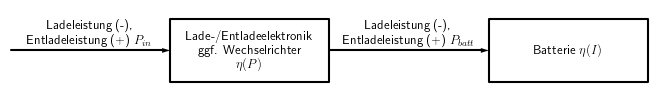

In [5]:
d = schemdraw.Drawing()
d += flow.Arrow().right().label('Ladeleistung (-), \nEntladeleistung (+) $P_{in}$').length(5)
d += (smps := flow.Box(w=5, h=2).anchor('W').label('Lade-/Entladeelektronik \n ggf. Wechselrichter\n $\eta(P)$'))
d += flow.Arrow().right().label('Ladeleistung (-), \nEntladeleistung (+) $P_{batt}$').length(5).at(smps.E)
d += (batt := flow.Box(w=5, h=2).anchor('W').label('Batterie $\eta(I)$'))
d.draw()

Nun setzt man das in [Abschnitt Wirkungsgradkennlinien verarbeiten](http://jfmay.gitlab.io/systemtechnik-fuer-energieeffizienz/08/SYE-efficiencycurve.html) beschriebene Verfahren an, um für jeden Zeitpunkt des Lastprofils die resultierende Leistung zu ermitteln. Vereinfachend kann man dabei annehmen, dass die Effizienz des Ladegeräts in beide Richtungen in gleicher Weise von der Leistung abhängt und diese mithilfe des Leistungsbetrags ermitteln.

### Verlustmechanismen in einem Batteriesystem

<a title="Alipour et.al., CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt" href="https://www.mdpi.com/batteries/batteries-06-00035/article_deploy/html/images/batteries-06-00035-g001.png"><img width="512" alt="Typical polarization of a cell" src="https://www.mdpi.com/batteries/batteries-06-00035/article_deploy/html/images/batteries-06-00035-g001.png"></a>

**Verluste einer Batteriezelle steigen mit dem Strom** {cite:p}`alipour_review_2020`: 
- *Innenwiderstand ($IR$ loss)*
- *Aktivierungsenergie für elektrochemische Reaktionen*: Reaktionsgeschwindigkeit an den Elektroden begrenzt den maximal verfügbaren Strom
- *Elektrolyt*: je besser die Ionen durch den Elektrolyt diffundieren können, desto geringer bremst der Elektrolyt den Anstieg des Stroms

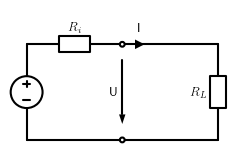

In [6]:
d = schemdraw.Drawing()
Ri = d.add(elm.RBOX, d='right', label='$R_i$') # Innenwiderstand
d.add(elm.DOT_OPEN)
li = d.add(elm.LINE, d='right')
d.add(elm.CurrentLabelInline(direction='in').at(li).label('I'))
d.add(elm.RBOX, d='down', label='$R_L$')
d.add(elm.LINE, d='left')
d.add(elm.DOT_OPEN)
d.add(elm.LINE, d='left')
sv = d.add(elm.SourceV, d='up')
d.add(elm.CurrentLabel(reverse = True, ofst=-3).at(sv).label('U'))
d.draw()

**Batteriezellverluste verringern**
- schneller laden $\to$ höherer Strom $\to$ höhere Verluste $\to$ geringerer Wirkungsgrad - Abhilfe: größere Batterie (verhältnismäßig geringere Ströme), Modellierung: 
 - Verluste stromabhängig recherchieren (Effizienz als Funktion der C-Rate)
 - dann bei Nennspannung die zugehörige Leistung ausrechnen und Verluste damit abschätzen
 - genauer wird es, wenn man Spannung und Strom separat modelliert - ist aber sehr aufwendig
- Selbstentladungsverluste durch geeignete Wahl der Zelle und Verschaltung minimieren (siehe auch Ladegerät)

**Verluste bei der Verschaltung von Batteriezellen und Abhilfe**:
- *Zellen überbrückbar einbinden*, da die schwächste Zelle in einer Serienschaltung den Strom bestimmt
- *Ladezustand balancieren*, um Spannung möglichst gleich zu halten in Parallelschaltungen, da die schwächste Zelle in einer Parallelschaltung die Spannung bestimmt
- *Aufgabe des Batteriemanagementsystems (BMS)*: Balancing und Sicherheitsabschaltungen des gesamten Batteriesystems oder einzelner Teile

**Verluste im Ladegerät**
- typischerweise bei Nennleistung bester Wirkungsgrad
- schneller laden $\to$ höherer Strom $\to$ geringere Verluste - Abhilfe: passend ausgewähltes Ladegerät
- Vorsicht: batterieschonende und sichere Ladeverfahren regeln den Strom typischerweise ab 70-80 Prozent des maximalen Ladezustands herunter $\to$ eigentlich ein separates Modell nötig, das nicht nur die Wirkungsgradkurve beinhaltet, sondern auch den Ladezustand

## Einsparpotenziale bei wiederaufladbaren Batterien ermitteln

### Messtechnisch

Energiebedarf über z. B. eine Woche messen
- gleichzeitig Akkunutzung aufzeichnen (z. B. Ladezustand der Staplerbatterien vor dem Laden und Häufigkeit der Ladevorgänge)
- mit Literaturwerten vergleichen

### Rechnerisch abschätzen anhand des einfachen Ersatzschaltbilds

Sowohl beim Laden als auch beim Entladen fließt Strom und Ohmsche Verluste entstehen. Die Klemmenspannung der Batterie hängt davon ab, wie viel Spannung über dem Innenwiderstand abfällt. Beim Laden wird der Strom negativ gezählt, daher liegt die Klemmenspannung der Batterie dann über der Leerlaufspannung. Beim Entladen wird der Strom positiv gezählt.

\begin{equation}
U = U_0 - I\cdot R_i 
\end{equation}

In [7]:
U0_example = 3.7 # V
Ri_example = .3 # Ohm

Als Beispiellastprofil wählen wir den Batteriestrom:\
2 Unterschieliche Beispiellastprofil von Batteriestrom werden verglichen

<AxesSubplot:>

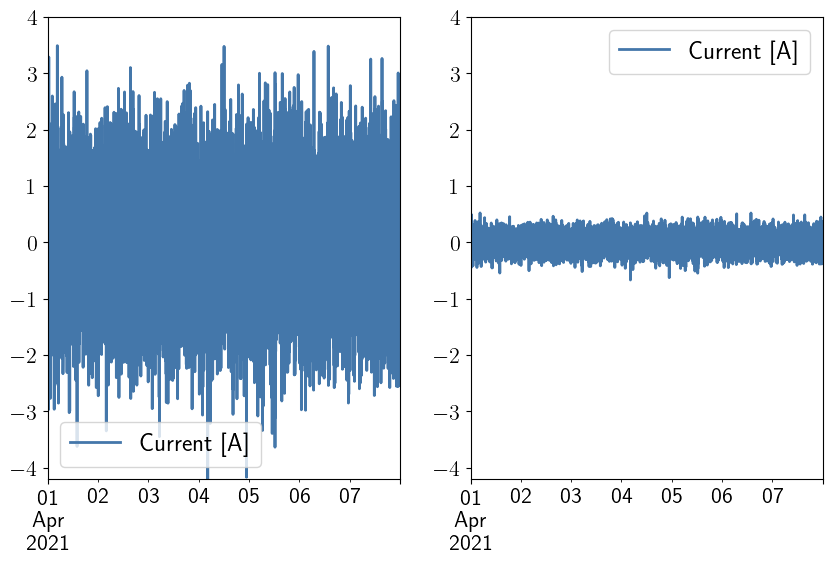

In [8]:
periods = 7 * 24 * 60
tidx = pd.date_range('2021-04-01', periods=periods, freq='T')
data = np.random.randn(periods)
ts = pd.DataFrame(data=data, index=tidx, columns = ['Current [A]'])
ts2 = 0.15*ts

figure, axes = plt.subplots(1, 2)
ts.plot(y='Current [A]', ax=axes[0], ylim=(-4.2,4))
ts2.plot(y='Current [A]', ax=axes[1], ylim=(-4.2,4))

Dazu kann man für jeden Zeitpunkt die Spannung ermitteln:

<AxesSubplot:>

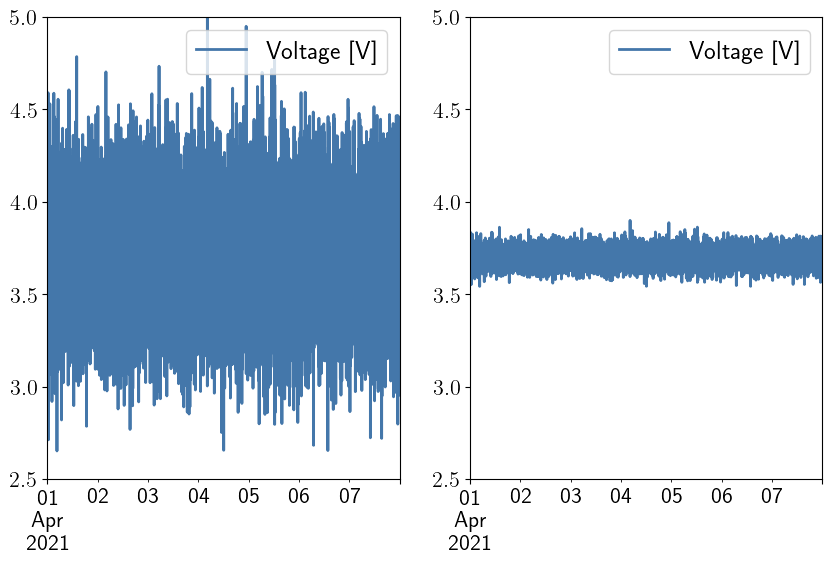

In [9]:
ts['Voltage [V]'] = U0_example - ts['Current [A]']*Ri_example
ts2['Voltage [V]'] = U0_example - ts2['Current [A]']*Ri_example

figure, axes = plt.subplots(1, 2)
ts.plot(y='Voltage [V]', ax=axes[0], ylim=(2.5,5))
ts2.plot(y='Voltage [V]', ax=axes[1], ylim=(2.5,5))

Daraus ergibt sich die Lade- bzw. Entladeleistung:

<AxesSubplot:>

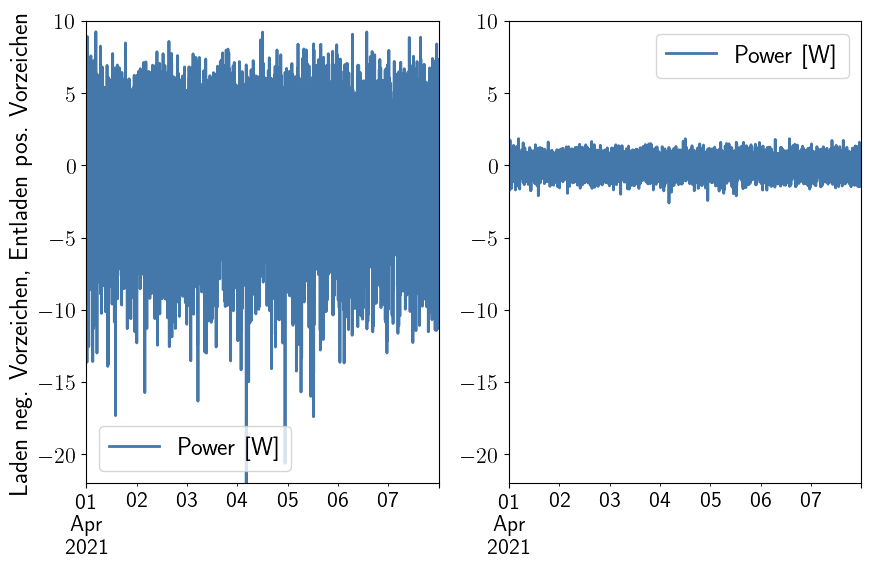

In [10]:
ts['Power [W]'] = ts['Voltage [V]']*ts['Current [A]']
ts2['Power [W]'] = ts2['Voltage [V]']*ts2['Current [A]']

figure, axes = plt.subplots(1, 2)

ax = ts.plot(y='Power [W]', ax=axes[0], ylim=(-22,10))
#plt.ylabel('Laden neg. Vorzeichen, Entladen pos. Vorzeichen')
ax.set_ylabel("Laden neg. Vorzeichen, Entladen pos. Vorzeichen")
ts2.plot(y='Power [W]', ax=axes[1], ylim=(-22,10))

Außerdem lassen sich die Verluste am Innenwiderstand ermitteln:

<AxesSubplot:>

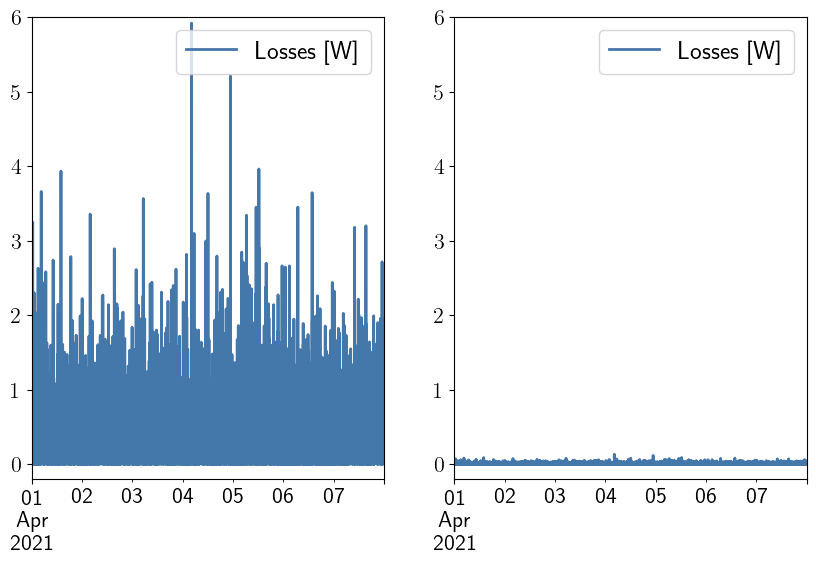

In [11]:
ts['Losses [W]'] = Ri_example*ts['Current [A]']**2
ts2['Losses [W]'] = Ri_example*ts2['Current [A]']**2

figure, axes = plt.subplots(1, 2)
ts.plot(y='Losses [W]', ax=axes[0], ylim=(-0.2,6))
ts2.plot(y='Losses [W]', ax=axes[1], ylim=(-0.2,6))

Die Batterieeffizienz zu jedem Zeitpunkt beträgt dann:

<AxesSubplot:>

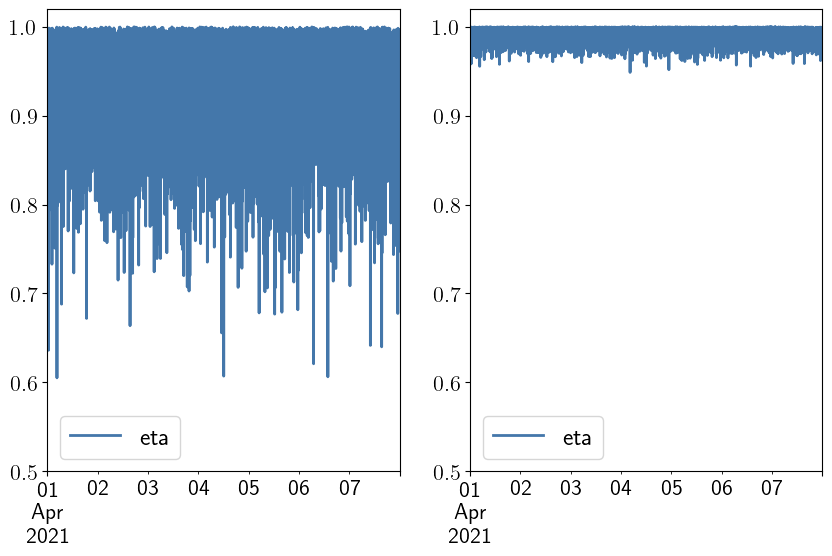

In [12]:
ts['eta'] = (ts['Power [W]'].abs() - ts['Losses [W]'])/ts['Power [W]'].abs()
ts2['eta'] = (ts2['Power [W]'].abs() - ts2['Losses [W]'])/ts2['Power [W]'].abs()

figure, axes = plt.subplots(1, 2)
ts.plot(y='eta', ax=axes[0], ylim=(0.5,1.02))
ts2.plot(y='eta', ax=axes[1], ylim=(0.5,1.02))

Wenn man nun mit geeigneten Maßnahmen dafür sorgen kann, dass die Ströme kleiner werden und somit die Effizienz verbessert wird, dann lässt sich auch die Lade-/Entladeeffizienz der Batterie steigern.

### Ladezustand der Batterie berücksichtigen

Eine Batterie kann nicht mehr Energie entladen, als sie gespeichert hat und nicht mehr Energie laden, als ihre Kapazität erlaubt. Dies korrekt zu modellieren, ist etwas aufwendiger: Man müsste bei jedem Lade-/Entladevorgang vorher prüfen, ob die gewünschte Leistung möglich ist für den nächsten Zeitraum des Lastprofils. Ist sie es nicht, dann könnte die Batterie entsprechend nur weniger entladen oder laden. Dies würde beispielsweise beim Entladen dazu führen, dass die zugehörige Last, z. B. ein Motor, unterversorgt würde. Dies ist deutlich aufwendiger als das, was in diesem Modul erwartbar ist. Es gibt hierzu auch separate Module in python, die Sie in [Abschnitt Energietechnik modellieren mit python](http://jfmay.gitlab.io/systemtechnik-fuer-energieeffizienz/nb/SYE-energymodels-DE.html), finden.

Es gibt jedoch eine verhältnismäßig einfache Möglichkeit, zu überprüfen, ob die Batterie im erlaubten Rahmen geladen und entladen wird. Dafür notiert man an jedem Zeitpunkt den Ladezustand **state of charge (SOC)** und gibt eine Warnung aus, falls er unter 0 fällt oder über 1 geht. Um die Rechnung korrekt zu machen, ist es wichtig, mit der effektiv nutzbaren Kapazität der Batterie zu rechnen. Beispielsweise könnte auf dem Typenschild einer Batterie eine Nennkapazität von 2.3 Ah angegeben sein. Zusätzlich entnimmt man dem Datenblatt, dass es für eine lange Lebensdauer optimal ist, diese Batterie zwischen 20% und 80% SOC zu betreiben. So beträgt dann die nutzbare Kapazität:

In [13]:
CN = 2.3 # Ah
SOCmin = 0.2
SOCmax = 0.8
Ceff = CN*(SOCmax-SOCmin)
print('Die effektiv nutzbare Kapazität beträgt ' + str(np.round(Ceff,3)) + ' Ah')

Die effektiv nutzbare Kapazität beträgt 1.38 Ah


Zudem ist es wichtig, den Ladezustand zu Beginn des Lastprofils festzulegen.

In [14]:
SOCstart = 0.5

Nun lässt sich für jeden Zeitpunkt der entstehende Ladezustand berechnen:

<AxesSubplot:>

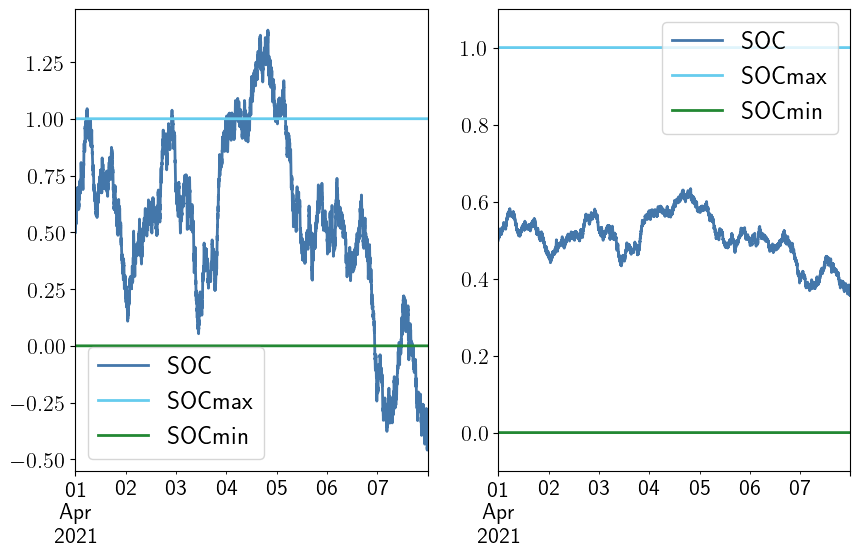

In [15]:
res = 60/(60*60) # s
ts['deltaSOC'] = ts['Current [A]']*res/Ceff
ts2['deltaSOC'] = ts2['Current [A]']*res/Ceff
ts['SOC']=(ts.deltaSOC.cumsum()+SOCstart).shift(1)
ts2['SOC']=(ts2.deltaSOC.cumsum()+SOCstart).shift(1)

ts.at['2021-04-01 00:00:00', 'SOC'] = SOCstart #Anfangswert von SOC
ts2.at['2021-04-01 00:00:00', 'SOC'] = SOCstart #Anfangswert von SOC
ts['SOCmax'] = 1
ts['SOCmin'] = 0
ts2['SOCmax'] = 1
ts2['SOCmin'] = 0
figure, axes = plt.subplots(1, 2)
ts.plot(y=['SOC','SOCmax','SOCmin'], ax=axes[0])
#, ylim=(-1.2,1.2)
ts2.plot(y=['SOC','SOCmax','SOCmin'], ax=axes[1], ylim=(-0.1,1.1))

In unserem Beispiel sollte sich der Ladezustand nur im erlaubten Bereich bewegen: er sollte steigt nicht über 1 und fällt nicht unter 0. Sollte er im unerlaubten Bereich sein, so ist in der Regel eine größere Batteriekapazität sinnvoll.\
Man sieht, dass der linke Ladezustand im unerlaubten Bereich liegt. Der rechte Ladezustand bei gewähltem Batterielastprofil liegt noch im erlaubten Bereich (nicht über 1 und fällt nicht unter 0).

Weiter verfeinern kann man die Betrachtung, wenn man annimmt, dass die verfügbare effektive Kapazität mit der Zeit sinkt, d.h. dass mit der Alterung (siehe unten) weniger in die Batterie passt.

```{bibliography}
:filter: docname in docnames
```